In [15]:
import numpy as np

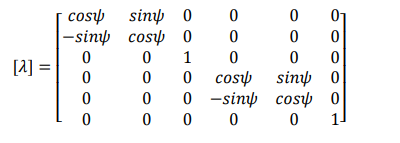

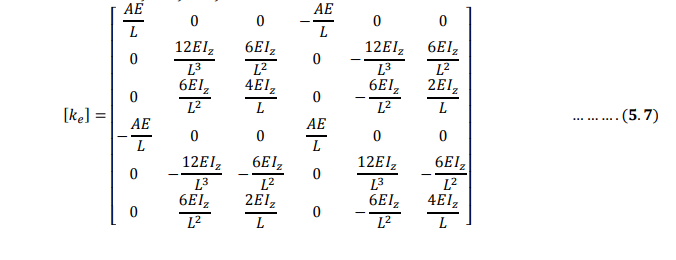

In [262]:
class Beam:
    def __init__(self, modulus_elasticity = None, moment_inertia = None, length = None, area = None, material_stiffness= None, element_connection = None, nodes = None, elements = None, theta = None, node_status = None, load_status = None):
        self.modulus_elasticity = modulus_elasticity 
        self.moment_inertia = moment_inertia 
        self.length = length 
        self.area = area 
        self.nodes = nodes
        self.element_connection = element_connection
        self.material_stiffness = material_stiffness
        self.elements = elements
        self.stiffness_list = []
        self.global_stiffness_matrix = []        
        self.theta = theta
        self.node_status = node_status
        self.load_status = load_status
        self.dof = len(next(iter(self.node_status.values())))

    def transform_lambda(self, idx):
        theta = self.theta[idx]
        mat = np.array([[np.cos(np.radians(theta)), np.sin(np.radians(theta)), 0, 0, 0, 0],
                        [-np.sin(np.radians(theta)), np.cos(np.radians(theta)), 0, 0, 0, 0],
                        [0, 0, 1, 0, 0, 0],
                        [0, 0, 0, np.cos(np.radians(theta)), np.sin(np.radians(theta)), 0],
                        [0, 0, 0, -np.sin(np.radians(theta)), np.cos(np.radians(theta)), 0],
                        [0, 0, 0, 0, 0, 1]
                        ])
        return mat
    
    def truncate_stiffness(self, stiffness):
        if (self.dof == 2):
            stiffness = np.delete(np.delete(stiffness, [0,3], axis=0), [0,3], axis=1)
        return stiffness
    
    def element_stiffness_2D(self, idx):

        area = self.area[idx] or 0
        length = self.length[idx]
        moment_inertia = self.moment_inertia[idx]
        
        transform_matrix = self.transform_lambda(idx)
        a_len = area/length
        m_len_3 = moment_inertia/length**3
        m_len_2 = moment_inertia/length**2
        m_len = moment_inertia/length

        stiffness = self.modulus_elasticity[idx] * np.array([[a_len, 0, 0, -a_len, 0, 0],
                                    [0, 12*m_len_3, 6*m_len_2, 0, -12*m_len_3, 6*m_len_2],
                                    [0, 6*m_len_2, 4*m_len, 0, -6*m_len_2, 2*m_len],
                                    [-a_len, 0, 0, a_len, 0, 0],
                                    [0, -12*m_len_3, -6*m_len_2, 0, 12*m_len_3, -6*m_len_2],
                                    [0, 6*m_len_2, 2*m_len, 0, -6*m_len_2, 4*m_len]
                                    ])

        transform_stiffness = np.matmul(transform_matrix, stiffness)
        transform_stiffness = np.matmul(transform_stiffness, transform_matrix.T)

        transform_stiffness = self.truncate_stiffness(transform_stiffness)
        return transform_stiffness

    def spring_element_stiffness_2D(self,idx):
        K = self.material_stiffness[idx]
        C = np.round(np.cos(np.radians(self.theta[idx])), 5) 
        S = np.round(np.sin(np.radians(self.theta[idx])), 5) 
        
        stiffness = K*np.array([[C*C, C*S, 0,-C*C, -C*S,0],
                                [C*S, S*S, 0, -C*S, -S*S,0],
                                [0, 0, 0, 0, 0, 0],
                                [-C*C, -C*S,0, C*C, C*S,0],
                                [-C*S, -S*S, 0, C*S, S*S,0],
                                [0, 0, 0, 0, 0, 0]
                                ])
        

        stiffness = self.truncate_stiffness(stiffness)
        return stiffness            
    
    def global_stiffness_matrix_2D(self):
        dof = self.dof
        self.global_stiffness_matrix = np.zeros((self.nodes*dof, self.nodes*dof), dtype = 'float')
        
        
        for n,stiffness in enumerate(self.stiffness_list):
            active_element = n+1
            i, j = self.element_connection[active_element]
            i = i * dof - dof
            j = j * dof - dof
                      
            self.global_stiffness_matrix[i:i+dof, i:i+dof] += stiffness[0:dof, 0:dof]
            self.global_stiffness_matrix[j:j+dof, j:j+dof] += stiffness[dof:,dof:]
            self.global_stiffness_matrix[i:i+dof, j:j+dof] += stiffness[0:dof, dof:]
            self.global_stiffness_matrix[j:j+dof, i:i+dof] += stiffness[dof:,0:dof]

        return self.global_stiffness_matrix
    
    def displacement(self, stiffness_matrix, load):

        return np.linalg.solve(stiffness_matrix, load)

    def reaction_force(self, disp_vector, fixed_node):
        reaction_force = []
        for pos in fixed_node:
            reaction_force.append(round(float(np.matmul(self.global_stiffness_matrix[pos],disp_vector)),2))
        return reaction_force

    def vectors_2D(self):
        dof = self.dof
        load_vector = np.zeros((self.nodes*dof,1), dtype = 'float')
        fixed_node_pos = []
        flexible_node_pos = []
        for node,status in self.node_status.items():
            i = node*dof-dof
            for j in range(dof):
                if(not status[j]):
                    fixed_node_pos.append(i+j)
                else:
                    flexible_node_pos.append(i+j)

        for node, load in self.load_status.items():
            i = node*dof-dof
            for j in range(dof):
                load_vector[i+j] = load[j]
        
        return [fixed_node_pos, flexible_node_pos, load_vector]

    def sub_matrix(self, matrix, pos):
        return matrix[np.ix_(pos, pos)]
    
    
    def get_local_stiffness(self):
        for element in range(self.elements):
            if (self.material_stiffness[element]):
                self.stiffness_list.append(self.spring_element_stiffness_2D(idx = element))
            else:
                self.stiffness_list.append(self.element_stiffness_2D( idx = element))
        return self.stiffness_list

    def get_global_stiffness(self):
        if self.stiffness_list is []:
            self.get_local_stiffness() 
        self.global_stiffness_matrix_2D()
        return self.global_stiffness_matrix
        
    def solve_problem(self):
        
        self.get_local_stiffness()
        
        self.global_stiffness_matrix_2D()
        
        fixed_node_pos, flexible_node_pos, load_vector = self.vectors_2D()
        
        flexible_global_stiffness = self.sub_matrix(self.global_stiffness_matrix, flexible_node_pos)
        flexible_load_vector = load_vector[flexible_node_pos]
        
        displacement_vector = np.zeros((self.nodes*self.dof,1), dtype='float')

        displacement_vector[flexible_node_pos] = self.displacement(flexible_global_stiffness, flexible_load_vector)
        reaction_forces = self.reaction_force(displacement_vector,fixed_node_pos)
        
        return [load_vector, displacement_vector, reaction_forces]
        
    
    

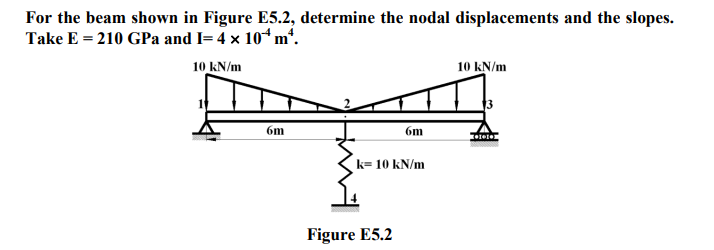

In [160]:
n_nodes = 4
area = [None, None, None]
modulus_elasticity = [210e09, 210e09, None]
moment_inertia = [4e-04, 4e-04, None]
material_stiffness = [None, None, 10e03]
theta = [0, 0, -90]
length = [6, 6, None]
elements = 3
element_connection = {1:[1,2], 2:[2,3], 3:[2,4]}
# load_status = {2:[8000,-12000]}
node_status = {1:[0,1], 2:[1,1], 3:[0,1]}

In [161]:
q1 = Beam(elements=elements,modulus_elasticity = modulus_elasticity, moment_inertia = moment_inertia, length = length, area = area, material_stiffness= material_stiffness, element_connection = element_connection, nodes = n_nodes, theta = theta, node_status = node_status)
local_stiffness, global_stiffness, fixed_node_pos, flexible_node_pos, load_vec = q1.solve_problem()


AttributeError: 'NoneType' object has no attribute 'items'

In [153]:
print(local_stiffness)

[array([[ 4.66666667e+06,  1.40000000e+07, -4.66666667e+06,
         1.40000000e+07],
       [ 1.40000000e+07,  3.36000000e+08, -1.40000000e+07,
         1.68000000e+08],
       [-4.66666667e+06, -1.40000000e+07,  4.66666667e+06,
        -1.40000000e+07],
       [ 1.40000000e+07,  1.68000000e+08, -1.40000000e+07,
         3.36000000e+08]]), array([[ 4.66666667e+06,  1.40000000e+07, -4.66666667e+06,
         1.40000000e+07],
       [ 1.40000000e+07,  3.36000000e+08, -1.40000000e+07,
         1.68000000e+08],
       [-4.66666667e+06, -1.40000000e+07,  4.66666667e+06,
        -1.40000000e+07],
       [ 1.40000000e+07,  1.68000000e+08, -1.40000000e+07,
         3.36000000e+08]]), array([[ 10000.,      0., -10000.,      0.],
       [     0.,      0.,      0.,      0.],
       [-10000.,      0.,  10000.,      0.],
       [     0.,      0.,      0.,      0.]])]


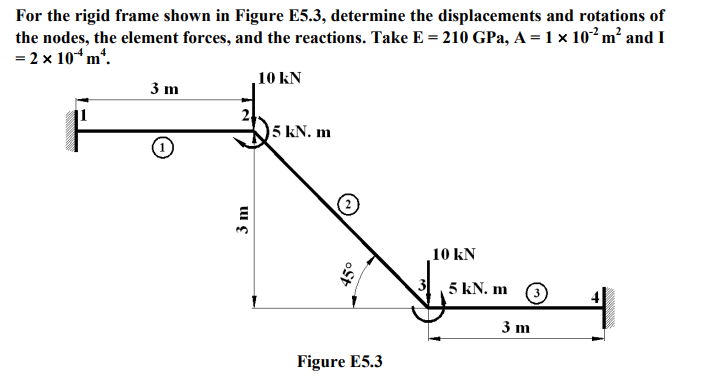

In [263]:
n_nodes = 4
area = [1e-02, 1e-02, 1e-02]
modulus_elasticity = [210e09, 210e09, 210e09]
moment_inertia = [2e-04, 2e-04, 2e-04]
material_stiffness = [None, None, None]
theta = [0, -45, 0]
length = [3, 4.2464, 3]
elements = 3
element_connection = {1:[1,2], 2:[2,3], 3:[3,4]}
load_status = {2:[0, -10e03, -5e03], 3:[0, -10e03, 5e03]}
node_status = {1:[0,0,0], 2:[1,1,1], 3:[1,1,1], 4:[0,0,0] }

In [264]:
ex_5_3 = Beam(elements = elements, modulus_elasticity= modulus_elasticity, moment_inertia=moment_inertia, length = length, area = area, material_stiffness= material_stiffness, element_connection = element_connection, nodes = n_nodes, theta = theta, node_status=node_status, load_status = load_status)

In [265]:
ex_5_3.get_global_stiffness()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
ex_5_3 = Beam(elements=elements, modulus_elasticity=modulus_elasticity, moment_inertia = moment_inertia, length = length, area = area, material_stiffness= material_stiffness, element_connection = element_connection, nodes = n_nodes, theta = theta, node_status=node_status, load_status = load_status)
load_vec, displacement_vector, reaction_forces = ex_5_3.solve_problem()

In [245]:
local_stiffness

[array([[ 7.00000000e+08,  0.00000000e+00,  0.00000000e+00,
         -7.00000000e+08,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.86666667e+07,  2.80000000e+07,
          0.00000000e+00, -1.86666667e+07,  2.80000000e+07],
        [ 0.00000000e+00,  2.80000000e+07,  5.60000000e+07,
          0.00000000e+00, -2.80000000e+07,  2.80000000e+07],
        [-7.00000000e+08,  0.00000000e+00,  0.00000000e+00,
          7.00000000e+08,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -1.86666667e+07, -2.80000000e+07,
          0.00000000e+00,  1.86666667e+07, -2.80000000e+07],
        [ 0.00000000e+00,  2.80000000e+07,  2.80000000e+07,
          0.00000000e+00, -2.80000000e+07,  5.60000000e+07]]),
 array([[ 2.50559350e+08,  2.43977199e+08, -9.88197477e+06,
         -2.50559350e+08, -2.43977199e+08, -9.88197477e+06],
        [ 2.43977199e+08,  2.50559350e+08,  9.88197477e+06,
         -2.43977199e+08, -2.50559350e+08,  9.88197477e+06],
        [-9.88197477e+06,  9.8

In [246]:
fixed_node_pos

[0, 1, 2, 9, 10, 11]

In [247]:
flexible_node_pos

[3, 4, 5, 6, 7, 8]

In [209]:
load_vec

array([[     0.],
       [     0.],
       [     0.],
       [     0.],
       [-10000.],
       [ -5000.],
       [     0.],
       [-10000.],
       [  5000.],
       [     0.],
       [     0.],
       [     0.]])

In [212]:
np.round(displacement_vector, 10)

array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.        ],
       [-0.00142378],
       [-0.00059204],
       [ 0.        ],
       [-0.00142378],
       [ 0.00059204],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

In [211]:
reaction_forces

[0.0, 10000.0, 23288.57, -0.0, 10000.0, -23288.57]

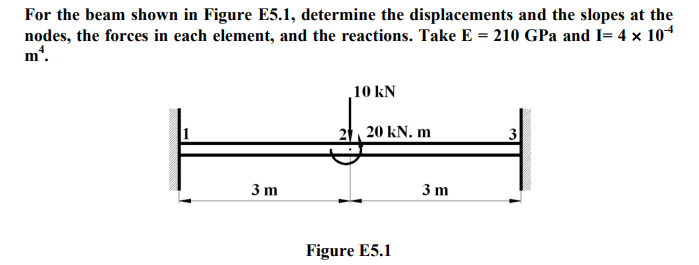

In [226]:
n_nodes = 3
area = [None, None]
modulus_elasticity = [210e09, 210e09]
moment_inertia = [4e-04, 4e-04]
material_stiffness = [None, None]
theta = [0, 0]
length = [3, 3]
elements = 2
element_connection = {1:[1,2], 2:[2,3]}
load_status = {2:[-10e03, 20e03]}
node_status = {1:[0,0], 2:[1,1], 3:[0,0] }

In [227]:
ex_5_1 = Beam(elements=elements, modulus_elasticity=modulus_elasticity, moment_inertia = moment_inertia, length = length, area = area, material_stiffness= material_stiffness, element_connection = element_connection, nodes = n_nodes, theta = theta, node_status=node_status, load_status = load_status)
load_vec, displacement_vector, reaction_forces = ex_5_1.solve_problem()

In [228]:
global_stiffness

array([[ 3.73333333e+07,  5.60000000e+07, -3.73333333e+07,
         5.60000000e+07,  0.00000000e+00,  0.00000000e+00],
       [ 5.60000000e+07,  1.12000000e+08, -5.60000000e+07,
         5.60000000e+07,  0.00000000e+00,  0.00000000e+00],
       [-3.73333333e+07, -5.60000000e+07,  7.46666667e+07,
         0.00000000e+00, -3.73333333e+07,  5.60000000e+07],
       [ 5.60000000e+07,  5.60000000e+07,  0.00000000e+00,
         2.24000000e+08, -5.60000000e+07,  5.60000000e+07],
       [ 0.00000000e+00,  0.00000000e+00, -3.73333333e+07,
        -5.60000000e+07,  3.73333333e+07, -5.60000000e+07],
       [ 0.00000000e+00,  0.00000000e+00,  5.60000000e+07,
         5.60000000e+07, -5.60000000e+07,  1.12000000e+08]])

In [229]:
displacement_vector

array([[ 0.00000000e+00],
       [ 0.00000000e+00],
       [-1.33928571e-04],
       [ 8.92857143e-05],
       [ 0.00000000e+00],
       [ 0.00000000e+00]])

In [230]:
reaction_forces

[10000.0, 12500.0, 0.0, -2500.0]

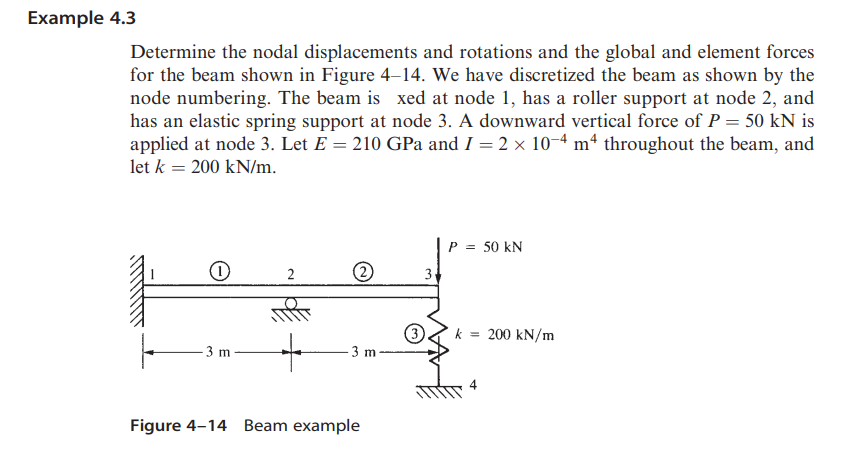

In [238]:
n_nodes = 4
area = [None, None, None]
modulus_elasticity = [210e09, 210e09, None]
moment_inertia = [2e-04, 2e-04, None]
material_stiffness = [None, None, 200e03]
theta = [0, 0, -90]
length = [3, 3, None]
elements = 3
element_connection = {1:[1,2], 2:[2,3], 3:{3,4}}
load_status = {3:[-50e03, 0]}
node_status = {1:[0,0], 2:[0,1], 3:[1,1], 4:[0,0] }

In [239]:
EX_4_3 = Beam(elements=elements, modulus_elasticity=modulus_elasticity, area=area, moment_inertia=moment_inertia, length=length, material_stiffness=material_stiffness, element_connection=element_connection, nodes=n_nodes, theta=theta, node_status=node_status, load_status=load_status)
load_vec, displacement_vector, reaction_forces = EX_4_3.solve_problem()

[[ 1.86666667e+07  2.80000000e+07 -1.86666667e+07  2.80000000e+07
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.80000000e+07  5.60000000e+07 -2.80000000e+07  2.80000000e+07
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.86666667e+07 -2.80000000e+07  3.73333333e+07  0.00000000e+00
  -1.86666667e+07  2.80000000e+07  0.00000000e+00  0.00000000e+00]
 [ 2.80000000e+07  2.80000000e+07  0.00000000e+00  1.12000000e+08
  -2.80000000e+07  2.80000000e+07  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.86666667e+07 -2.80000000e+07
   1.88666667e+07 -2.80000000e+07 -2.00000000e+05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.80000000e+07  2.80000000e+07
  -2.80000000e+07  5.60000000e+07  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -2.00000000e+05  0.00000000e+00  2.00000000e+05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   

In [240]:
displacement_vector

array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.00249169],
       [-0.01744186],
       [-0.00747508],
       [ 0.        ],
       [ 0.        ]])

In [241]:
reaction_forces

[-69767.44, -69767.44, 116279.07, 3488.37, 0.0]